## Jupyter Notebook to test prediction results

This scripts import the dataset then try to plot some results to 

1. Plot ground truth images 
2. Plot prediction images
3. Calculate R and P

### Prepatation

Data Import and Prepare

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from utils import imageUtils
from utils import postProcessing
from utils import MultiDefectDetectionDataset
from utils import evaluation
from utils import visualization
import numpy as np
import os
from chainercv.links import FasterRCNNVGG16
from chainercv.visualizations import vis_bbox
from chainercv.utils import write_image
import chainer
import math
from chainercv import utils
%matplotlib inline
import matplotlib.pyplot as plt

In [18]:
#load Data
root = './data/Data3TypesYminXminYmaxXmax2'
dataset = MultiDefectDetectionDataset(data_dir=root, split='train')
dataset_test = MultiDefectDetectionDataset(data_dir=root, split='test')
bbox_label_names = ('111', 'dot','100')

In [19]:
# DataSet Statistics
print('total number of training images: ', len(dataset))
print('total number of test images: ', len(dataset_test))
print('type of defects: ', bbox_label_names)

total number of training images:  64
total number of test images:  12
type of defects:  ('111', 'dot', '100')


### Show Data Set

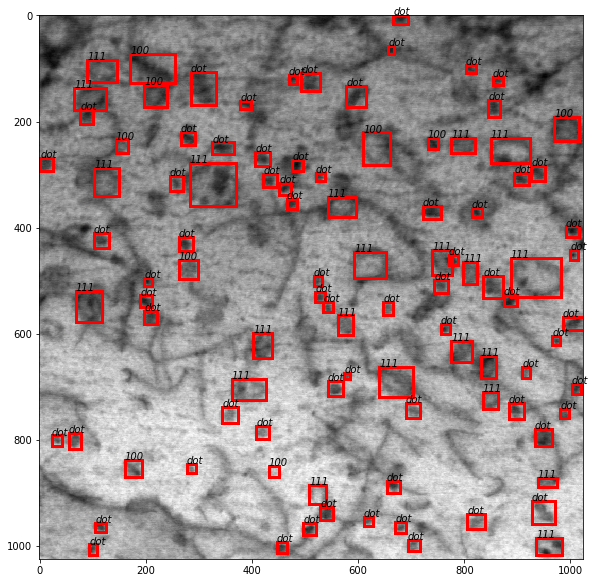

In [7]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, label = dataset[33]
visualization.vis_bbox(img, bbox, label, label_names=bbox_label_names, ax=ax1)
plt.show()

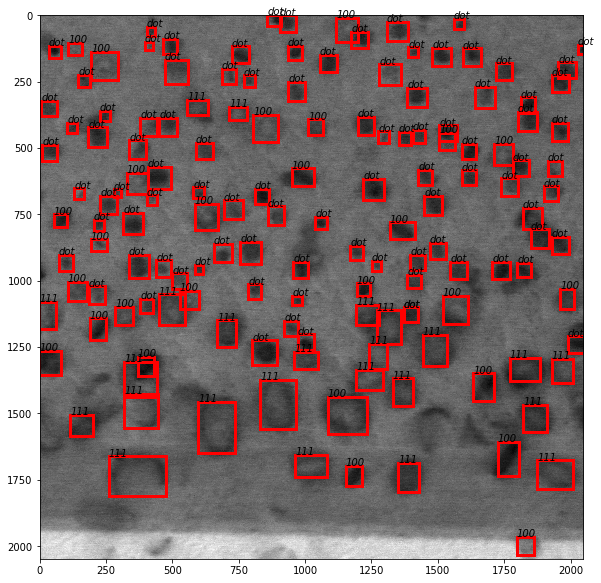

In [7]:
# Another Figure
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, label = dataset[50]
visualization.vis_bbox(img, bbox, label, label_names=bbox_label_names, ax=ax1)
plt.show()

# Testing

Set `use_gpu = False` because we use CPU to do testing

In [20]:
use_gpu = False
proposal_params = {'min_size': 8}
model = FasterRCNNVGG16(n_fg_class=3, pretrained_model='./modelResults/snapshot_model_100000_20180831_oldDataSet.npz', ratios=[ 0.5, 1, 1.5, 2, 2.5, 3, 3.5,4],anchor_scales=[1, 4, 8, 16], min_size=1024, max_size=1024,proposal_creator_params=proposal_params)

if use_gpu:
    chainer.cuda.get_device_from_id(0).use()
    model.to_gpu()
    
bbox_label_names = ('111loop', 'dot','100loop')

#### View Prediction Results

#### First figure

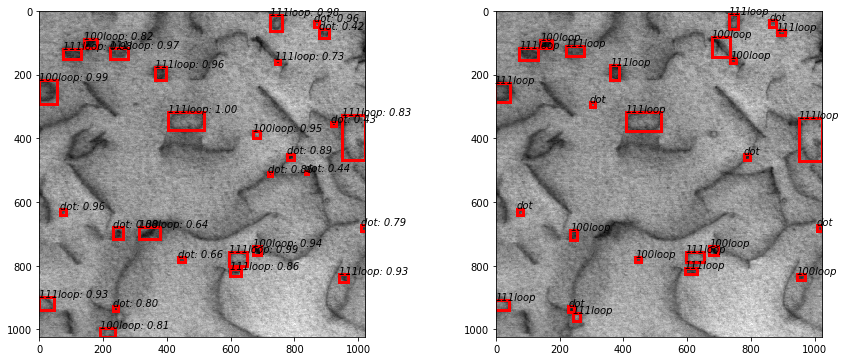

In [21]:
# Prediction of first image
img_1, bbs_1, lbs1 = dataset_test[1]
model.score_thresh = 0.4
bboxes, labels, scores = model.predict([img_1])
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
# plot prediction
visualization.vis_bbox(img_1, bboxes[0], labels[0], scores[0], label_names=bbox_label_names, ax=ax1)
# plot ground truth
visualization.vis_bbox(img_1, bbs_1, lbs1, label_names=bbox_label_names,ax=ax2)

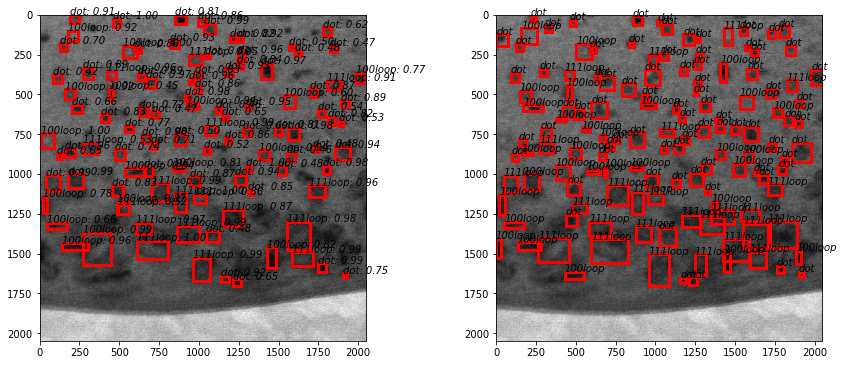

In [23]:
# Prediction of Second image
img_1, bbs_1, lbs1 = dataset_test[10]
model.score_thresh = 0.4
bboxes, labels, scores = model.predict([img_1])
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
# plot prediction
visualization.vis_bbox(img_1, bboxes[0], labels[0], scores[0], label_names=bbox_label_names, ax=ax1)
# plot ground truth
visualization.vis_bbox(img_1, bbs_1, lbs1, label_names=bbox_label_names,ax=ax2)

## Evaluation

In [9]:
from utils import evaluate_set_by_centroid
from utils import evaluate_set_by_centroid_kind
from utils import evaluate_set_by_defect_size
from utils import pr_plot_by_size

In [18]:
# Test the code of calculate P and R by the defect kinds instead of just using the overall data
dataset_test_short = MultiDefectDetectionDataset(data_dir=root, split='shorttest')
%time recalls, precisions = evaluate_set_by_centroid_kind(model,bbox_label_names, dataset_test_short, threshold=0.05)
print("Average recall ", sum(recalls)/len(recalls))
print("Average precision ", sum(precisions)/len(precisions))

FileNotFoundError: [Errno 2] No such file or directory: './data/Data3TypesYminXminYmaxXmax2/shorttestimages.txt'

# Validation Set test

In [22]:
# Using Validation Set
dataset_test_validation = MultiDefectDetectionDataset(data_dir=root, split='test')
%time recalls, precisions = evaluate_set_by_centroid(model,dataset_test_validation , threshold=0.1)
print("Average recall ", sum(recalls)/len(recalls))
print("Average precision ", sum(precisions)/len(precisions))

CPU times: user 4min 59s, sys: 1min 27s, total: 6min 27s
Wall time: 5min 31s
Average recall  0.8756652449555631
Average precision  0.7166631148838839


In [ ]:
%time recalls, precisions = evaluate_set_by_centroid(model, dataset_test, threshold=0.001)
print("Average recall ", sum(recalls)/len(recalls))
print("Average precision ", sum(precisions)/len(precisions))

In [23]:
# loop over from a list of possible threshold values 
# According to ChainerCV Document
# > algorithm runs with a very low score_thresh so that bounding boxes with low scores are kept. It is known that lower score_thresh produces higher mAP.
# try values from [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
threshodVal = [0.9, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
recall_List = list()
precision_List = list()

for valItem in threshodVal:
    print(valItem)
    recalls, precisions = evaluate_set_by_centroid(model, dataset_test, threshold= valItem)
    recall_List.append(sum(recalls)/len(recalls))
    precision_List.append(sum(precisions)/len(precisions) )

0.9


0.5


0.1


0.05


0.01


0.005


0.001


0.0005


0.858, 0.255, 0.393
0.767, 0.686, 0.724
0.679, 0.814, 0.740
0.663, 0.829, 0.737
0.630, 0.841, 0.720
0.618, 0.842, 0.713
0.603, 0.856, 0.707
0.601, 0.856, 0.706
0.591, 0.856, 0.700


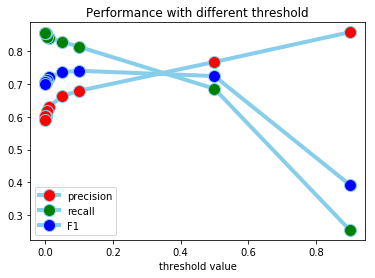

In [ ]:
F1_List = list()
for i in range(0,len(recall_List)):
    F1 = (2 * precision_List[i]* recall_List[i])/(precision_List[i]+recall_List[i])
    print("%.3f, %.3f, %.3f" % (precision_List[i],recall_List[i],F1))
    F1_List.append(F1)
    

# Plotting Results
import matplotlib.pyplot as plt
fignow = plt.figure()
plt.plot( threshodVal, precision_List, marker='o', markerfacecolor='red', markersize=12, color='skyblue', linewidth=4, label='precision')
plt.plot( threshodVal, recall_List, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=4,label='recall')
plt.plot( threshodVal, F1_List, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='F1')
plt.title("Performance with different threshold")
plt.xlabel('threshold value')
plt.legend()
plt.show()
fignow.savefig("F1-model20180831_dataset2.png",format = "png")



##### Plot Results Summary of different kinds

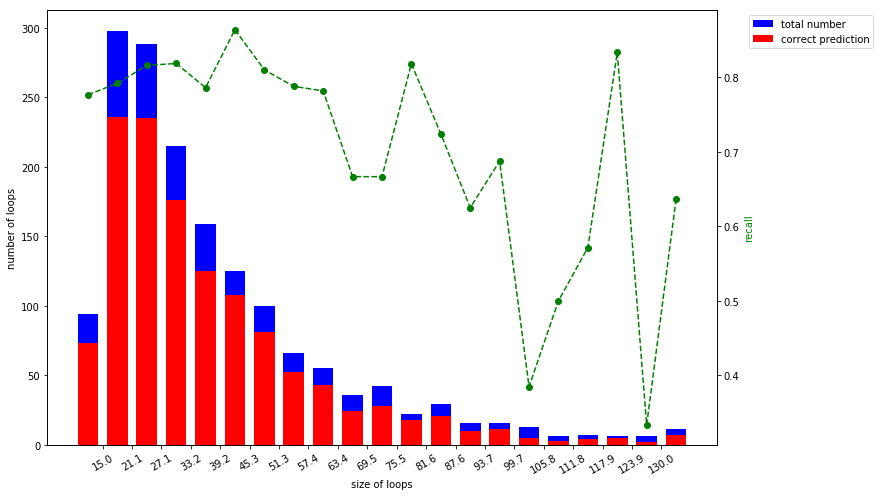

In [14]:
bins = 20
sz_range = (15,130)
recalls, precisions = evaluate_set_by_defect_size(model, dataset_test, num_bins=bins, size_range=sz_range, threshold=0.05)
pr_plot_by_size(recalls, label='recall', num_bins=bins, size_range=sz_range)

In [ ]:
import os
print(os.getcwd())